Log-Gabor Filter
==========

This is an implementation of the Log-Gabor Filter.

In [1]:
# Common imports (you may not end up using all of them)
import numpy as np
import numpy.fft as fft
import scipy.ndimage as ndi
import skimage as ski
import skimage.io as io
import skimage.exposure as ex
import matplotlib.pylab as plt
import math

import skimage.filters as filters

plt.gray() # set default to grayscale

<Figure size 432x288 with 0 Axes>

In [2]:
if os.path.isdir('ImageProcessingF2021'):
    !git -C ImageProcessingF2021 pull
else:
    !git clone https://github.com/MoravianCollege/ImageProcessingF2021.git

Already up to date.


Purpose of Log Gabor Filter
===
The Log-Gabor filter is able to describe a signal in terms of the local frequency responses. The main benefit of using a Log Gabor Filter is to capture natural elements of images over it's predecesor the Gabor Filter. The Log-Gabor seems to be somewhat of an outcast in the world of signal processisng other than in the domain of Image Processing for that reason listed above. The primairy objective of the log gabor filter is edge detection.  The Log-Gabor filter has also been used in applications such as speech analysis, contour detection, texture synthesis and image denoising among others.

What does it actually do though?
That can be summed up by saying it analyzes whether there is any specific frequency content in the image in specific directions in a localized region around the point or region of analysis.

First Step Of Creating Log Gabor
===
The first step is to compute a matrix the same size of the image where every value of the matrix contains the normalized value. The values range from 0 at the middle to 0.5 at the boundary

G(f) = \exp \left(  \frac{- \left(  \log (f/f_0) \right )^2}{2 \left( \log( \sigma /f_0) \right) ^2} \right)
equation for convolving gaussian kernal with image
Filters
Filters are constructed in terms of two components.
The radial component, which controls the frequency band that the filter responds to
The angular component, which controls the orientation that the filter responds to.

Angular Component
===
Now we calculate the angular component that controls the orientation selectivity of the filter. This pretty much uses a gaussian kernel to align the polarity of the kernel to match with the orientation.

In [52]:
def create_log_gabor_x_y(size):
    '''
    Creates the x and y grids of the log gabor filter
    these grids are used to create the gaussian aspect

    Arguments:
        size    width and height of the kernel. must be an integer equal or greater than 3 and odd.

    Returns:
        the x and y grids
    '''
    
    if size < 3 or size % 2 == 0 or (not isinstance(size, int)):
        raise ValueError('size is invalid value: ' + str(size))

    num_rows = size
    num_cols = size

    x = np.arange(-(num_cols // 2), (num_cols // 2) + 1) / num_cols
    y = np.arange(-(num_rows // 2), (num_rows // 2) + 1) / num_rows
    [x,y] = np.meshgrid(x, y)

    return x, y

In [53]:
def create_log_gabor_radial_component(x, y, size, wavelength, sigma):
    '''
    Creates the radial component of the Log-Gabor filter

    Arguments:
        x           the x grid
        y           the y grid
        size        width and height of the kernel. must be an integer equal or greater than 3 and odd.
        wavelength  determines the frequency
        sigma       controls the bandwith of the filter

    Returns:
        a 2D numpy image representing the radial component of the log-gabor filter
    '''

    num_rows = size
    num_cols = size

    radius = np.sqrt(x**2 + y**2)

    radius[(num_rows // 2), (num_cols // 2)] = 1

    frequency = 1.0 / wavelength

    radial_component = np.exp((-(np.log(radius/frequency)) ** 2) / (2 * (np.log(sigma) ** 2)))
    radial_component[num_rows // 2, num_cols // 2] = 0

    return radial_component


In [54]:
def create_log_gabor_angular_component(x, y, angle, theta_sigma):
    '''
    a 2D numpy image with the shape (size, size) representing the angular component of a log-gabor filter

    Arguments:
        x           the x grid
        y           the y grid
        angle       angle in radians for the orientation of the angular component
        theta_sigma the standard deviation

    Returns:
        an image representing the angular component of a Log-Gabor filter
    '''
    # calculate the angular component that controls the orientation selectivity of the filter.
    theta = np.arctan2(-y, x)
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)

    # difference in sine and cosine
    diff_sin = sin_theta * np.cos(angle) - cos_theta * np.sin(angle)
    diff_cos = cos_theta * np.cos(angle) + sin_theta * np.sin(angle)

    # calculate absolute angular distance
    distance_theta = np.abs(np.arctan2(diff_sin, diff_cos))

    # calc angular component
    angular_component = np.exp((-distance_theta ** 2) / (2 * (theta_sigma ** 2)))
    
    return angular_component

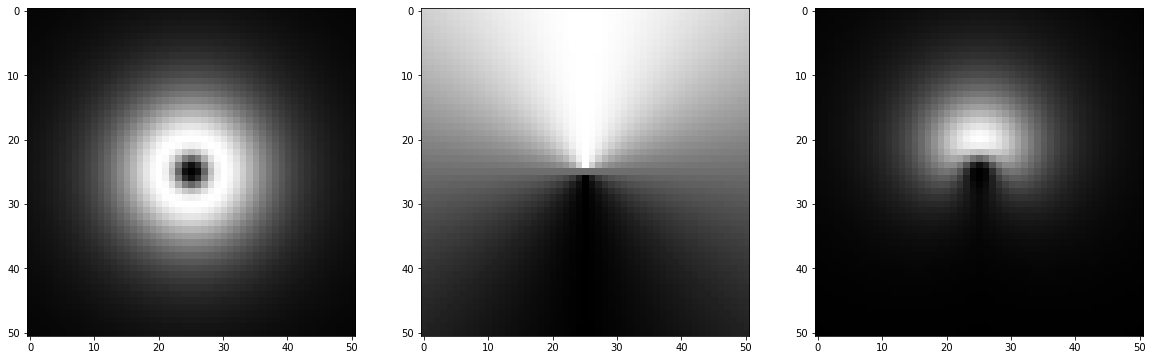

In [57]:
def create_log_gabor_kernel(size=7, wavelength=3, sigma=0.5, angle=np.pi/2, theta_sigma=1.25):
    '''
    Creates the Log-Gabor kernel that can be used to convolve an image.

    Arguments:
        size        size (width and height) of the kernel
        wavelength  determines the frequency of the kernel
        sigma       controls the bandwith of the filter
        angle       angle in radians for the orientation of the angular component
        theta_sigma the standard deviation

    Returns:
        a Log-Gabor kernel
    '''

    x, y = create_log_gabor_x_y(size)
    radial_component = create_log_gabor_radial_component(x, y, size, wavelength, sigma)
    angular_component = create_log_gabor_angular_component(x, y, angle, theta_sigma)
    final_kernel = angular_component * radial_component

    plt.figure(figsize=(20, 20))

    plt.subplot(1, 3, 1)
    plt.imshow(radial_component)

    plt.subplot(1, 3, 2)
    plt.imshow(angular_component)

    plt.subplot(1, 3, 3)
    plt.imshow(final_kernel)

    return final_kernel

create_log_gabor_kernel(size=51, wavelength=10)
pass


In [58]:
def create_log_gabor_filter_bank(size, min_wave_length=10, sigma=0.55, scaling_factor=3, num_scales=3, num_orientations=6, theta_sigma=1.5):
    """
    Creates a filter bank of Log-Gabor kernels that vary based on frequency and orientation.
    This filter bank can be used to capture all of the features in an image.

    Arguments:
        size            size (width and height) of the kernel
        min_wave_length determines the minimum frequency of the kernel
        sigma           controls the bandwith of the filter
        scaling_factor  how much the wave_length is scaled every time to get a new wavelength
        num_scales      the number of times to repeatedly scale the minimum frequency
        num_orientations the number of directions that should be used for the angular component
        theta_sigma     the standard deviation

    Returns:
        a Log-Gabor kernel
    """
    if min_wave_length < 3:
        raise ValueError('min_wave_length must at least be 3. It is: ' + str(min_wave_length))

    x, y = create_log_gabor_x_y(size)

    angular_components = []
    for orientation in range(num_orientations):
        angle = 2 * math.pi * (orientation / num_orientations)
        ac = create_log_gabor_angular_component(x, y, angle, theta_sigma)
        angular_components.append(ac)

    radial_components = []
    wavelength = min_wave_length
    for _ in range(num_scales):
        rc = create_log_gabor_radial_component(x, y, size, wavelength, sigma)
        radial_components.append(rc)

        wavelength *= scaling_factor

    filter_bank = []
    for rc in radial_components:
        for ac in angular_components:
            filter_bank.append(rc * ac)
    return filter_bank


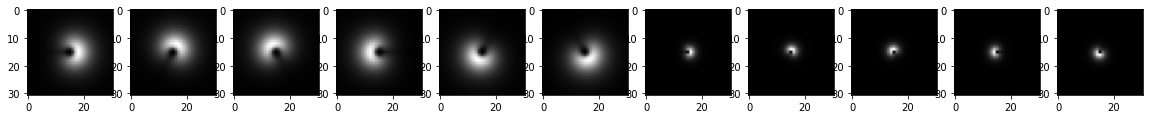

In [60]:
random_filter_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

filter_bank = create_log_gabor_filter_bank(31)

plt.figure(figsize=(20, 20))

for i, filter_value in enumerate(random_filter_values):
    plt.subplot(1, len(random_filter_values), i+1)
    plt.imshow(filter_bank[filter_value])


In [63]:
def apply_filter_bank(im, filter_bank):
    """
    Applies a filter bank to an image by accumulating the maximum of every convolution
    of the image with a filter.

    Arguments:
        im          the image to apply the filter bank to
        filter_bank the filter bank which  is a list of kernels

    Returns:
        the accumulation of applying all of the filters in the filter bank to the image
    """
    accumulation = np.ones(shape=im.shape)
    for k in filter_bank:
        accumulation = np.maximum(accumulation, ndi.convolve(im, k))
    return accumulation


Text(0.5, 1.0, 'filtered')

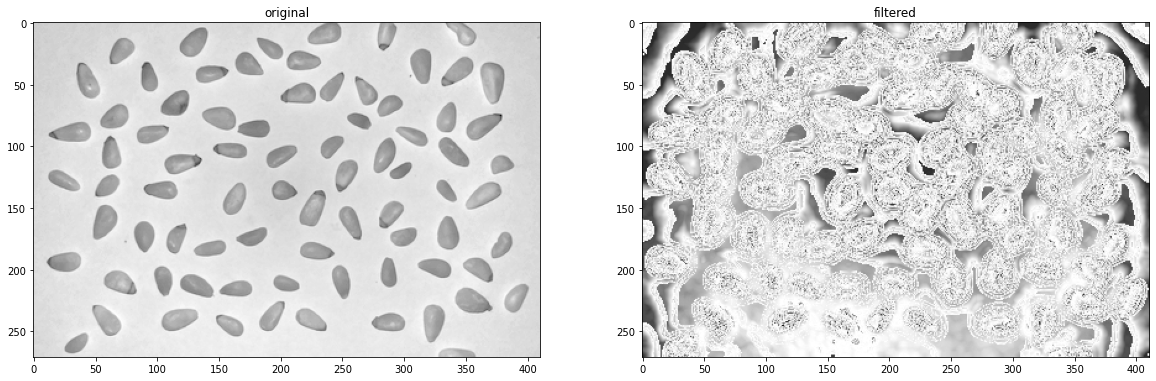

In [64]:
im = io.imread('ImageProcessingF2021/images/pinenuts.png')

filter_bank = create_log_gabor_filter_bank(31)
filtered_im = apply_filter_bank(im, filter_bank)

plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
plt.imshow(im)
plt.title('original')

plt.subplot(1, 2, 2)
plt.imshow(filtered_im)
plt.title('filtered')

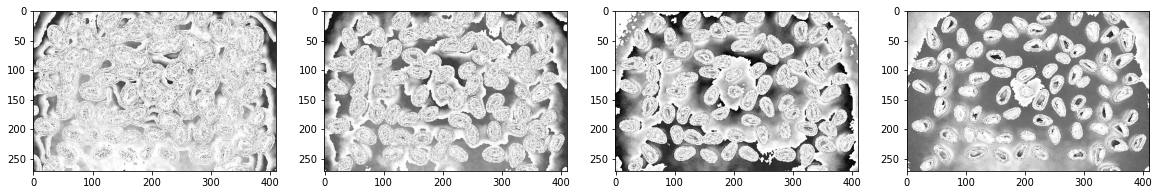

In [72]:
# Using different Sigma Values

plt.figure(figsize=(20, 20))

arr = [0.55, 0.65, 0.75, 0.85]
for i, value in enumerate(arr):
    plt.subplot(1, len(arr), i+1)
    filter_bank = create_log_gabor_filter_bank(31, sigma=value)
    filtered_im = apply_filter_bank(im, filter_bank)
    plt.imshow(filtered_im)


Text(0.5, 1.0, 'Gaussian 50% with LG Filter')

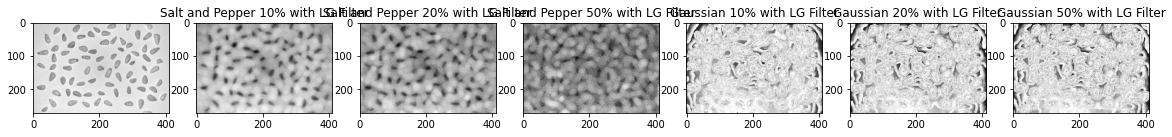

In [70]:
from skimage.util import random_noise
im = io.imread('ImageProcessingF2021/images/pinenuts.png')

plt.figure(figsize=(20, 20))

# plotting with various noise
plt.subplot(1,7,1)
plt.imshow(im)

filter_bank = create_log_gabor_filter_bank(31)

plt.subplot(1,7,2)
noisy = random_noise(im, 's&p', amount=0.1)
plt.imshow(apply_filter_bank(noisy, filter_bank))
plt.title('Salt and Pepper 10% with LG Filter')

plt.subplot(1,7,3)
noisy = random_noise(im, 's&p', amount=0.2)
plt.imshow(apply_filter_bank(noisy, filter_bank))
plt.title('Salt and Pepper 20% with LG Filter')

plt.subplot(1,7,4)
noisy = random_noise(im, 's&p', amount=0.5)
plt.imshow(apply_filter_bank(noisy, filter_bank))
plt.title('Salt and Pepper 50% with LG Filter')

plt.subplot(1,7,5)
noisy = ndi.gaussian_filter(im, sigma=0.1)
plt.imshow(apply_filter_bank(noisy, filter_bank))
plt.title('Gaussian 10% with LG Filter')

plt.subplot(1,7,6)
noisy = ndi.gaussian_filter(im, sigma=0.2)
plt.imshow(apply_filter_bank(noisy, filter_bank))
plt.title('Gaussian 20% with LG Filter')

plt.subplot(1,7,7)
noisy = ndi.gaussian_filter(im, sigma=0.5)
plt.imshow(apply_filter_bank(noisy, filter_bank))
plt.title('Gaussian 50% with LG Filter')
